<a href="https://colab.research.google.com/github/jooalee64/mastertip/blob/main/mastip_correct_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook Summary

This notebook sets up a PyTorch dataset and model for detecting the mast tip of a sailboat within a detected hull bounding box.

1.  **Setup and Data Loading**: Mounts Google Drive, imports necessary libraries, defines paths for images and CSV labels, and sets up constants like image dimensions and device.
2.  **Data Loading Functions**: Includes functions to load YOLO-formatted bounding box data from CSV files.
3.  **Custom Dataset Class**: Defines a `MastTipCSVDataset` that loads images, hull bounding boxes, and mast tip coordinates. It also includes preprocessing steps like resizing and padding images to a fixed size (1024x1024) and transforming bounding box and tip coordinates accordingly.
4.  **Dataset Initialization**: Initializes train, validation, and test datasets using the defined paths and the `MastTipCSVDataset` class.
5.  **Data Inspection**: Includes a cell to inspect the columns of the hull and tip CSV files to ensure they have the expected format.
6.  **DataLoader Initialization**: Sets up DataLoaders for training, validation, and testing, and shows a sample from the training dataset.
7.  **Model Definition**: Defines the `TipNet` model, which uses a ResNet18 backbone, applies ROIAlign to extract features from the hull bounding boxes, and then uses a small head network to predict the mast tip coordinates within the ROI.
8.  **Training Function**: Defines `train_one_epoch` function to perform one epoch of training using MSE loss.
9.  **Visualization Functions**: Includes functions to visualize a sample with hull and tip, and a function to run inference on a single image and visualize the predicted mast tip. There are also commented-out functions for visualizing hull vs. prediction and evaluating the model (calculating Mean NME).

In [39]:

from google.colab import drive
drive.mount('/gdrive')

import os, glob, csv, math, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Code with Comments

In [40]:
# Import necessary libraries from Python standard library, third-party libraries, and PyTorch.
# google.colab.drive is used to mount Google Drive to access data.
# os, glob, csv, math, random are standard Python libraries for various utilities.
# numpy is used for numerical operations.
# pandas is used for data manipulation and reading CSV files.
# PIL (Pillow) is used for image processing.
# matplotlib.pyplot is used for plotting and visualization.
# torch and its modules (nn, F, utils.data) are the core PyTorch components for building and training neural networks.
# torchvision.transforms.functional (TF) is used for image transformations.
from google.colab import drive
drive.mount('/gdrive')

import os, glob, csv, math, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [41]:
# Define the root directory for the project data, assuming it's stored in Google Drive.
ROOT_DIR = "/gdrive/MyDrive/boats"
# Define the directory containing the images.
IMG_DIR = os.path.join(ROOT_DIR, "yolo/images")
# Define the directory containing the label CSV files.
CSV_DIR = os.path.join(ROOT_DIR, "yolo/labels-storage/stage-b-labels")

# Define a dictionary mapping train/val/test splits to the corresponding hull label CSV files.
HULL_CSV = {
    "train": os.path.join(CSV_DIR, "hull-labels", "hull-train.csv"),
    "val": os.path.join(CSV_DIR, "hull-labels", "hull-val.csv"),
    "test": os.path.join(CSV_DIR, "hull-labels", "hull-test.csv")
}
# Define a dictionary mapping train/val/test splits to the corresponding mast tip label CSV files.
TIP_CSV = {
    "train": os.path.join(CSV_DIR, "tip-labels", "train-tips-csv.csv"),
    "val": os.path.join(CSV_DIR, "tip-labels", "val-tips-csv.csv"),
    "test": os.path.join(CSV_DIR, "tip-labels", "test-tips-csv.csv")
}

# Define a dictionary mapping train/val/test splits to their respective image subdirectories.
IMG_SUBDIRS = {s: os.path.join(IMG_DIR, s) for s in ["train", "val", "test"]}

# Define the maximum side length for resizing images. Images will be resized to fit within a square of this size.
MAX_SIDE = 1024
# Determine the device to use for training and inference (GPU if available, otherwise CPU).
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# Define a function to load YOLO-formatted bounding box data from a CSV file.
# This function is not used in the MastTipCSVDataset class but might be a utility function.
def load_yolo_csv(path):
    out = {}
    # Read the CSV file into a pandas DataFrame.
    df = pd.read_csv(path)
    # Iterate through each row of the DataFrame.
    for _, row in df.iterrows():
        # Extract the base filename (without extension) from the 'image_name' column.
        base = os.path.splitext(os.path.basename(row['image_name']))[0]
        # Extract YOLO bounding box coordinates (cx, cy, w, h) as floats.
        cx, cy, w, h = float(row['bbox_x']), float(row['bbox_y']), float(row['bbox_width']), float(row['bbox_height'])
        # Store the bounding box coordinates in a dictionary, keyed by the base filename.
        # Each key can have multiple bounding boxes (a list of lists).
        out.setdefault(base, []).append([cx, cy, w, h])
    return out

In [43]:
# Define a custom PyTorch Dataset for loading images, hull bounding boxes, and mast tip coordinates.
class MastTipCSVDataset(Dataset):
    # Initialize the dataset with image directory and paths to hull and tip CSV files.
    def __init__(self, image_dir, hull_csv, tip_csv):
        self.image_dir = image_dir
        # Load hull bounding box data from the specified CSV.
        self.hulls = self._load_hull_csv(hull_csv)
        # Load mast tip coordinate data from the specified CSV.
        self.tips = self._load_tip_csv(tip_csv)
        # Get a sorted list of all image paths in the image directory.
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

    # Return the total number of samples in the dataset.
    def __len__(self): return len(self.image_paths)

    # Load hull bounding box data from a CSV file.
    def _load_hull_csv(self, path):
        out = {}
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            base = os.path.splitext(os.path.basename(row['image_name']))[0]
            # Coordinates are assumed to be in pixel space relative to the original image.
            cx, cy, w, h = float(row['bbox_x']), float(row['bbox_y']), float(row['bbox_width']), float(row['bbox_height'])
            out.setdefault(base, []).append([cx, cy, w, h])
        return out

    # Load mast tip coordinate data from a CSV file.
    def _load_tip_csv(self, path):
        out = {}
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            base = os.path.splitext(os.path.basename(row['image_name']))[0]
            # Coordinates are assumed to be in pixel space relative to the original image.
            cx, cy = float(row['tip_x']), float(row['tip_y'])
            out.setdefault(base, []).append([cx, cy])
        return out

    # Get a sample (image and annotations) at the given index.
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        # Open the image and convert it to RGB format.
        img = Image.open(path).convert("RGB")
        orig_W, orig_H = img.size
        base = os.path.splitext(os.path.basename(path))[0]

        # Calculate the scaling factor to resize the image while maintaining aspect ratio.
        scale = min(MAX_SIDE / orig_W, MAX_SIDE / orig_H)
        # Calculate the new dimensions after resizing.
        new_W, new_H = int(orig_W * scale), int(orig_H * scale)
        # Resize the image using bilinear interpolation.
        img_resized = img.resize((new_W, new_H), Image.BILINEAR)
        # Create a new canvas (square image) with a gray background.
        canvas = Image.new("RGB", (MAX_SIDE, MAX_SIDE), (114, 114, 114))
        # Calculate padding to center the resized image on the canvas.
        pad_x, pad_y = (MAX_SIDE - new_W) // 2, (MAX_SIDE - new_H) // 2
        # Paste the resized image onto the center of the canvas.
        canvas.paste(img_resized, (pad_x, pad_y))

        # --- Debug visualization (keep commented unless needed) ---
        # plt.imshow(canvas)
        # plt.title(f"Canvas Image - {base}")
        # plt.axis("off")
        # plt.show()
        # ---------------------------------------------------------

        # Helper function to convert original [cx, cy, w, h] coordinates to [x1, y1, x2, y2] in the canvas coordinate system.
        def to_xyxy(c, scale, pad_x, pad_y):
            # Input c is [cx, cy, w, h] in original pixel coordinates
            cx, cy, w, h = c
            x1 = cx * scale + pad_x
            y1 = cy * scale + pad_y
            x2 = (cx + w) * scale + pad_x
            y2 = (cy + h) * scale + pad_y
            return [x1, y1, x2, y2]

        # Helper function to convert original [cx, cy] coordinates to [cx, cy] in the canvas coordinate system.
        def to_xy(c, scale, pad_x, pad_y):
            # Input c is [cx, cy] in original pixel coordinates
            cx, cy = c
            return [cx * scale + pad_x, cy * scale + pad_y]

        # Apply the coordinate transformations to hull bounding boxes and tip points.
        hull_boxes = [to_xyxy(c, scale, pad_x, pad_y) for c in self.hulls.get(base, [])]
        tip_points = [to_xy(c, scale, pad_x, pad_y) for c in self.tips.get(base, [])]

        # Return a dictionary containing the processed image (as a PyTorch tensor),
        # hull bounding boxes, tip points, and the original image path.
        return {
            "image": TF.to_tensor(canvas),
            "hulls": torch.tensor(hull_boxes, dtype=torch.float32),
            "tips": torch.tensor(tip_points, dtype=torch.float32),
            "img_path": path
        }

In [44]:
# Initialize the training, validation, and test datasets using the defined paths and the custom dataset class.
train_ds = MastTipCSVDataset(IMG_SUBDIRS["train"], HULL_CSV["train"], TIP_CSV["train"])
val_ds   = MastTipCSVDataset(IMG_SUBDIRS["val"], HULL_CSV["val"], TIP_CSV["val"])
test_ds  = MastTipCSVDataset(IMG_SUBDIRS["test"], HULL_CSV["test"], TIP_CSV["test"])

# Print the number of samples in each dataset split.
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 1050, Val: 225, Test: 225


In [45]:
# Import pandas for data inspection.
import pandas as pd

# This cell is for inspecting the columns of the CSV files to ensure they match the expected format
# for the dataset loading functions.

# Try to read the hull training CSV file and print its column names.
try:
    df_hull_train = pd.read_csv(HULL_CSV["train"])
    print("Columns in hull-train.csv:")
    print(df_hull_train.columns)
except FileNotFoundError:
    # Handle the case where the hull training CSV file is not found.
    print(f"Error: File not found at {HULL_CSV['train']}")

# Try to read the tip training CSV file and print its column names.
try:
    df_tip_train = pd.read_csv(TIP_CSV["train"])
    print("\nColumns in train-tips-csv.csv:")
    print(df_tip_train.columns)
except FileNotFoundError:
    # Handle the case where the tip training CSV file is not found.
    print(f"Error: File not found at {TIP_CSV['train']}")

Columns in hull-train.csv:
Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height'],
      dtype='object')

Columns in train-tips-csv.csv:
Index(['tip_label', 'tip_x', 'tip_y', 'image_name', 'image_width',
       'image_height'],
      dtype='object')


In [46]:
# Import DataLoader from torch.utils.data.
from torch.utils.data import DataLoader

# Create DataLoaders for the training, validation, and test datasets.
# DataLoaders provide an iterable over the dataset, supporting batching, shuffling, and multiprocessing.
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True) # Shuffle training data, drop the last incomplete batch
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False) # Do not shuffle validation data
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False) # Use batch size 1 for testing

# Print information about a sample from the training dataset to verify its structure and content.
print("Sample from train_ds:")
sample = train_ds[0] # Get the first sample from the training dataset
print("Image shape:", sample["image"].shape) # Print the shape of the image tensor
print("Hull boxes:", sample["hulls"]) # Print the hull bounding box tensor
print("Tip points:", sample["tips"]) # Print the mast tip coordinate tensor

Sample from train_ds:
Image shape: torch.Size([3, 1024, 1024])
Hull boxes: tensor([[ 91.5963, 499.4587, 258.3486, 520.5963]])
Tip points: tensor([[185.5413, 281.0367]])


In [47]:
# Import necessary modules from torchvision.
import torchvision.models as models
from torchvision.ops import roi_align

# Define the TipNet model using a PyTorch Module.
class TipNet(nn.Module):
    # Initialize the model.
    def __init__(self):
        super().__init__()
        # Load a pre-trained ResNet18 model with default weights.
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Remove the average pooling and fully connected layers from the backbone.
        layers = list(backbone.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        # Define the ROIAlign operation.
        # roi_align expects boxes in the format [batch_index, x1, y1, x2, y2].
        # output_size=(7,7) means the output feature map for each ROI will be 7x7.
        # spatial_scale=1/32 is the ratio of input image spatial size to feature map spatial size (for ResNet18, it's 32).
        # aligned=True provides more precise alignment.
        self.roi_align = lambda feats, boxes: roi_align(feats, boxes, output_size=(7,7), spatial_scale=1/32, aligned=True)
        # Define the head network that takes the pooled ROI features and predicts the mast tip coordinates.
        self.tip_head = nn.Sequential(
            nn.Conv2d(512, 128, 3, padding=1), # Convolutional layer
            nn.ReLU(), # ReLU activation
            nn.AdaptiveAvgPool2d((1,1)), # Adaptive average pooling to reduce spatial dimensions to 1x1
            nn.Flatten(), # Flatten the feature map
            nn.Linear(128, 2) # Fully connected layer to output 2 coordinates (x, y)
        )

    # Define the forward pass of the model.
    # x is the input image tensor, roi_boxes is a list of bounding boxes for each image in the batch.
    def forward(self, x, roi_boxes):
        # Pass the input image through the backbone to get feature maps.
        feats = self.backbone(x)
        # Prepare the bounding boxes for ROIAlign.
        rois = []
        # Iterate through each image in the batch and its corresponding bounding boxes.
        for i, boxes in enumerate(roi_boxes):
            # Iterate through each bounding box for the current image.
            for box in boxes:
                # Concatenate the batch index (as a float tensor) with the bounding box coordinates.
                rois.append(torch.cat([torch.tensor([i], device=x.device, dtype=torch.float32), box])) # Ensure batch index is float32
        # Stack the prepared ROI tensors.
        # If there are no ROIs in the batch, this will result in an empty list, which will cause an error when stacking.
        # A check for an empty rois list could be added here to handle cases with no detected hulls.
        if not rois:
            # Handle case with no ROIs - perhaps return None or a tensor of zeros depending on desired behavior
            return None # Or return torch.empty(...) with appropriate shape and device
        rois = torch.stack(rois)
        # Apply ROIAlign to extract features for each ROI.
        pooled = self.roi_align(feats, rois) # Pass the entire rois tensor
        # Pass the pooled features through the tip head to get the predicted tip coordinates.
        out = self.tip_head(pooled)
        return out

In [48]:
# Import tqdm for displaying progress bars.
from tqdm import tqdm
# Import functional from torch.nn for loss functions.
import torch.nn.functional as F

# Define the function to train the model for one epoch.
def train_one_epoch(model, loader, optimizer, device):
    # Set the model to training mode.
    model.train()
    total_loss = 0 # Initialize total loss for the epoch.
    num_batches = len(loader) # Get the number of batches in the data loader.

    # Iterate through batches in the data loader with a progress bar.
    for batch in tqdm(loader, desc="Training", leave=False):
        # Move image, tip, and hull data to the specified device.
        imgs = batch["image"].to(device, non_blocking=True)
        tips = batch["tips"].to(device, non_blocking=True)
        hulls = batch["hulls"].to(device, non_blocking=True)

        # Zero the gradients of the optimizer.
        optimizer.zero_grad()

        try:
            # Perform the forward pass: get predicted tip coordinates from the model.
            pred = model(imgs, hulls)
            # Check if the model returned None (e.g., if there were no ROIs).
            if pred is None:
                continue  # skip if model skipped empty RoI
            # Calculate the Mean Squared Error (MSE) loss between predicted and hull tips.
            # tips.view(-1, 2) reshapes the hull tips to match the shape of the predictions.
            loss = F.mse_loss(pred, tips.view(-1, 2))
            # Perform backpropagation to calculate gradients.
            loss.backward()
            # Update model weights using the optimizer.
            optimizer.step()
            # Add the current batch's loss to the total loss.
            total_loss += loss.item()
        except Exception as e:
            # Catch any exceptions during training and print a warning message.
            print(f"Skipping batch due to error: {e}")
            continue

    # Return the average loss for the epoch.
    return total_loss / num_batches

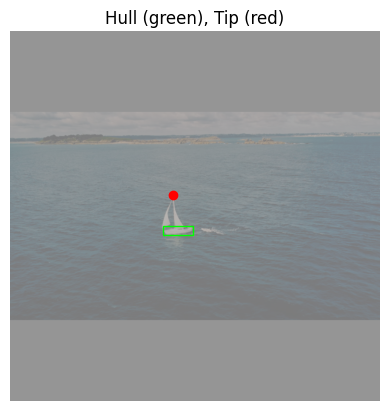

In [49]:
# Import matplotlib.pyplot for visualization.
import matplotlib.pyplot as plt
# Import numpy for numerical operations.
import numpy as np

# Define a function to visualize a sample with hull and tip.
def visualize_sample(sample):
    # Permute the dimensions of the image tensor to (height, width, channels) for matplotlib.
    img = sample["image"].permute(1,2,0).numpy()
    # Approximately reverse the normalization applied during data loading for visualization.
    # Note: The normalization applied in the dataset is TF.to_tensor, which scales to [0, 1].
    # The values 0.229 and 0.485 seem to be related to standard ImageNet normalization,
    # but the exact reverse normalization might depend on how the images were originally scaled before TF.to_tensor.
    # A more accurate reverse would be: img = img * std + mean for each channel, where std and mean are the values used for normalization.
    img = (img * 0.229 + 0.485)  # reverse normalization approx
    # Clip the pixel values to be within the valid range [0, 1].
    plt.imshow(np.clip(img, 0, 1))
    # Iterate through each hull bounding box in the sample.
    for box in sample["hulls"]:
        # Extract bounding box coordinates (x1, y1, x2, y2).
        x1, y1, x2, y2 = box.numpy()
        # Add a rectangle patch to the plot to visualize the hull bounding box (green outline, no fill).
        plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor="lime", fill=False))
    # Iterate through each mast tip point in the sample.
    for pt in sample["tips"]:
        # Plot the mast tip point as a red circle ('ro').
        plt.plot(pt[0], pt[1], "ro")
    # Set the title of the plot.
    plt.title("Hull (green), Tip (red)")
    # Turn off the axes.
    plt.axis("off")
    # Display the plot.
    plt.show()

# Visualize the first sample from the test dataset.
visualize_sample(test_ds[0])